# Transcript Analysis

In [91]:
%load_ext autoreload
%autoreload 2
import os
import re
import sys
import tqdm
import pickle
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

def find_transcripts(author_name):
	transcript_dir_path = '_Transcripts'
	for dir in os.listdir(transcript_dir_path):
		# check if dir and if author_name is in dir
		if os.path.isdir(os.path.join(transcript_dir_path, dir)) and author_name in dir:
			print(f'Found {author_name} in {transcript_dir_path}/{dir}.')
			transcript_paths = []
			for file in sorted(os.listdir(os.path.join(transcript_dir_path, dir)), reverse=True):
				transcript_paths.append(os.path.join(transcript_dir_path, dir, file))
			print(f' Found {len(transcript_paths)} transcripts.')
			return transcript_paths
	print(' Transcript Path not Found author:', os.path.join(os.getcwd(), author_name))
		
def read_transcript(transcript_name, transcript_dict):
	with open(transcript_name, 'r') as f:
		print(f'  Reading: {transcript_name}')
		for line in f:
			# title is the first line of the transcript, with # at the beginning
			if line[0] == '#':
				title = line[1:].strip()
			# date is in the second line of the transcript, between [ and ]
			# url is in the second line of the transcript, between ( and )
			elif line[:2] == '**':
				date = re.search(r'\[(.*?)\]', line).group(1)
				# conver date to datetime (December 6, 2023 -> 2023-12-06)
				date = datetime.datetime.strptime(date, '%B %d, %Y').strftime('%Y-%m-%d')
				# add year, month, day to the dict
				year = date[:4]
				month = date[5:7]
				day = date[8:]
				transcript_dict[title]['year'] = year
				transcript_dict[title]['month'] = month
				transcript_dict[title]['day'] = day
				# convert date to day of the week
				weekday = datetime.datetime.strptime(date, '%Y-%m-%d').strftime('%A')
				transcript_dict[title]['weekday'] = weekday
				url = re.search(r'\((.*?)\)', line).group(1)
				transcript_dict[title]['url'] = url
			else:
				# add the line to the transcript (taking out leading * and other formatting including ' and ")
				transcript_dict[title]['transcript'].append(str(line[3:].strip()))
		return transcript_dict

def dict_to_pandas(transcript_dict):
	transcript_df = pd.DataFrame(columns=['title', 'year', 'month', 'day', 'weekday', 'url', 'transcript'])
	for title, content in transcript_dict.items():
		new_row = {'title': title, 'year': content['year'], 
						   'month': content['month'], 'day': content['day'], 'weekday': content['weekday'],
							 'url': content['url'], 'transcript': content['transcript']}
		transcript_df = pd.concat([transcript_df, pd.DataFrame([new_row])], ignore_index=True)
	# sort by year, month, day and reset the index
	transcript_df = transcript_df.sort_values(by=['year', 'month', 'day'], ascending=False, ignore_index=True)
	return transcript_df

def pickle_transcript_df(transcript_df, author_name):
	print(f'Pickling {author_name} transcript_df.')
	dataframe_dir_path = '_Dataframes'
	if not os.path.exists(dataframe_dir_path):
		os.makedirs(dataframe_dir_path)
	transcript_df_name = f'{author_name}_transcript_df.pickle'
	df_path = os.path.join(dataframe_dir_path, transcript_df_name)
	with open(df_path, 'wb') as f:
		pickle.dump(transcript_df, f)
		print(f' Pickled {transcript_df_name} in {dataframe_dir_path}/.')

def main():
	# author_name = sys.argv[1]
	author_name = 'New York Times'
	transcripts = find_transcripts(author_name)
	transcript_dict = defaultdict(lambda: defaultdict(list))
	for transcript in transcripts:
		if '.md' in transcript:
			read_transcript(transcript, transcript_dict)
	transcript_df = dict_to_pandas(transcript_dict)
	pickle_transcript_df(transcript_df, author_name)
	return transcript_df
	
transcript_df = main()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found New York Times in _Transcripts/New York Times Podcasts.
 Found 23 transcripts.
  Reading: _Transcripts/New York Times Podcasts/20240326_New York Times Podcasts.md
  Reading: _Transcripts/New York Times Podcasts/20240325_New York Times Podcasts.md
  Reading: _Transcripts/New York Times Podcasts/20240324_New York Times Podcasts.md
  Reading: _Transcripts/New York Times Podcasts/20240322_New York Times Podcasts.md
  Reading: _Transcripts/New York Times Podcasts/20240321_New York Times Podcasts.md
  Reading: _Transcripts/New York Times Podcasts/20240320_New York Times Podcasts.md
  Reading: _Transcripts/New York Times Podcasts/20240319_New York Times Podcasts.md
  Reading: _Transcripts/New York Times Podcasts/20240318_New York Times Podcasts.md
  Reading: _Transcripts/New York Times Podcasts/20240317_New York Times Podcasts.md
  Reading: _Transcripts/New York Times Podcasts/20240315_New York Times

In [92]:
transcript_df

,title,year,month,day,weekday,url,transcript
0,The United States vs. the iPhone,2024,03,26,Tuesday,https://www.youtube.com/watch?v=T8ptU0-dBMU,"[From the New York Times, I'm Sabrina Tavernis..."
1,A Terrorist Attack in Russia,2024,03,25,Monday,https://www.youtube.com/watch?v=2prryDGW2GE,"[From the New York Times, I'm Sabrina Tavernes..."
2,The Sunday Read: ‘My Goldendoodle Spent a Week...,2024,03,24,Sunday,https://www.youtube.com/watch?v=3o1XQePIMS4,"[Hey, I'm Sam Apple. I'm a contributor to the ..."
3,Chuck Schumer on His Campaign to Oust Israel’s...,2024,03,22,Friday,https://www.youtube.com/watch?v=at3wpDsTpIA,"[From the New York Times, I'm Michael Bobarro...."
4,The Caitlin Clark Phenomenon,2024,03,21,Thursday,https://www.youtube.com/watch?v=ucqbkS_UWDk,"[From the New York Times, I'm Sabrina Tavernis..."
5,The Bombshell Case That Will Transform the Hou...,2024,03,20,Wednesday,https://www.youtube.com/watch?v=ZUg6HVO0o9w,"[From the New York Times, I'm Michael Bobarro...."
6,Trump’s Plan to Take Away Biden’s Biggest Adva...,2024,03,19,Tuesday,https://www.youtube.com/watch?v=vPjyfsC5aPc,"[From New York Times, I'm Michael Bobauro. Thi..."
7,Your Car May Be Spying on You,2024,03,18,Monday,https://www.youtube.com/watch?v=6_avb_9q0S8,"[From the New York Times, I'm Sabrina Tavernis..."
8,"The Sunday Read: ‘Sure, It Won an Oscar. But I...",2024,03,17,Sunday,https://www.youtube.com/watch?v=UP5EIJsuYj8,[My name is Joshua Hunt and I'm a contributor ...
9,A Journey Through Putin’s Russia,2024,03,15,Friday,https://www.youtube.com/watch?v=mrneKV-wt0A,"[From the New York Times, I'm Sabrina Tavernis..."


In [93]:
from utils import fuzzy_lookup
# perform fuzzy match for all words in target_word_list
target_word_list = ['Michael Barbaro', 'Sabrina Tavernisi', 'Israel']

max_fuzzy_list = defaultdict(list)
max_fuzzy_word_list = defaultdict(list)

for idx, transcript in enumerate(transcript_df['transcript']):
	pod_title = transcript_df.iloc[idx]['title']	
	pod_date = transcript_df.iloc[idx]['year'] + '-' + transcript_df.iloc[idx]['month'] + '-' + transcript_df.iloc[idx]['day']
	print(f'{pod_date}: {pod_title}')
	for target_word in target_word_list:
		max_fuzzy, max_fuzzy_word = fuzzy_lookup.fuzzy_matching(target_word, transcript)
		max_fuzzy_list[target_word].append(max_fuzzy)
		max_fuzzy_word_list[target_word].append(max_fuzzy_word)

# add the max_fuzzy and max_fuzzy_word to the transcript_df
for key in max_fuzzy_list.keys():
	transcript_df[f'max_fuzzy_{key}'] = max_fuzzy_list[key]
	transcript_df[f'max_fuzzy_word_{key}'] = max_fuzzy_word_list[key]

2024-03-26: The United States vs. the iPhone
  "Michael Barbaro" Match Score: 0.56   | Match: have about
  "Sabrina Tavernisi" Match Score: 1.0    | Match: Sabrina Tavernisi
  "Israel" Match Score: 0.9231 | Match: Israels
2024-03-25: A Terrorist Attack in Russia
  "Michael Barbaro" Match Score: 0.56   | Match: much about
  "Sabrina Tavernisi" Match Score: 0.8824 | Match: Sabrina Tavernese
  "Israel" Match Score: 0.6667 | Match: Visual
2024-03-24: The Sunday Read: ‘My Goldendoodle Spent a Week at Some Luxury Dog ‘Hotels.’ I Tagged Along.’
  "Michael Barbaro" Match Score: 0.5517 | Match: Michael Hughes
  "Sabrina Tavernisi" Match Score: 0.6111 | Match: Carolina University
  "Israel" Match Score: 0.6154 | Match: surface
2024-03-22: Chuck Schumer on His Campaign to Oust Israel’s Leader
  "Michael Barbaro" Match Score: 0.8667 | Match: Michael Bobarro
  "Sabrina Tavernisi" Match Score: 0.5926 | Match: bring very
  "Israel" Match Score: 1.0    | Match: Israel
2024-03-21: The Caitlin Clark Phe

,title,year,month,day,weekday,url,transcript,max_fuzzy_Michael Barbaro,max_fuzzy_word_Michael Barbaro,max_fuzzy_Sabrina Tavernisi,max_fuzzy_word_Sabrina Tavernisi,max_fuzzy_Israel,max_fuzzy_word_Israel
0,The United States vs. the iPhone,2024,03,26,Tuesday,https://www.youtube.com/watch?v=T8ptU0-dBMU,"[From the New York Times, I'm Sabrina Tavernis...",0.560000,have about,1.000000,Sabrina Tavernisi,0.923077,Israels
1,A Terrorist Attack in Russia,2024,03,25,Monday,https://www.youtube.com/watch?v=2prryDGW2GE,"[From the New York Times, I'm Sabrina Tavernes...",0.560000,much about,0.882353,Sabrina Tavernese,0.666667,Visual
2,The Sunday Read: ‘My Goldendoodle Spent a Week...,2024,03,24,Sunday,https://www.youtube.com/watch?v=3o1XQePIMS4,"[Hey, I'm Sam Apple. I'm a contributor to the ...",0.551724,Michael Hughes,0.611111,Carolina University,0.615385,surface
3,Chuck Schumer on His Campaign to Oust Israel’s...,2024,03,22,Friday,https://www.youtube.com/watch?v=at3wpDsTpIA,"[From the New York Times, I'm Michael Bobarro....",0.866667,Michael Bobarro,0.592593,bring very,1.000000,Israel
4,The Caitlin Clark Phenomenon,2024,03,21,Thursday,https://www.youtube.com/watch?v=ucqbkS_UWDk,"[From the New York Times, I'm Sabrina Tavernis...",0.560000,make about,1.000000,Sabrina Tavernisi,0.727273,viral
5,The Bombshell Case That Will Transform the Hou...,2024,03,20,Wednesday,https://www.youtube.com/watch?v=ZUg6HVO0o9w,"[From the New York Times, I'm Michael Bobarro....",0.642857,Michael thank,0.583333,in tens,0.923077,Israeli
6,Trump’s Plan to Take Away Biden’s Biggest Adva...,2024,03,19,Tuesday,https://www.youtube.com/watch?v=vPjyfsC5aPc,"[From New York Times, I'm Michael Bobauro. Thi...",0.866667,Michael Bobauro,0.600000,abortion have,0.666667,travel
7,Your Car May Be Spying on You,2024,03,18,Monday,https://www.youtube.com/watch?v=6_avb_9q0S8,"[From the New York Times, I'm Sabrina Tavernis...",0.560000,make about,1.000000,Sabrina Tavernisi,0.666667,insurance
8,"The Sunday Read: ‘Sure, It Won an Oscar. But I...",2024,03,17,Sunday,https://www.youtube.com/watch?v=UP5EIJsuYj8,[My name is Joshua Hunt and I'm a contributor ...,0.769231,Michael Bay,0.571429,saying this,0.666667,Visual
9,A Journey Through Putin’s Russia,2024,03,15,Friday,https://www.youtube.com/watch?v=mrneKV-wt0A,"[From the New York Times, I'm Sabrina Tavernis...",0.571429,Israel around,1.000000,Sabrina Tavernisi,1.000000,Israel


Text(0, 0.5, 'Number of Podcasts')

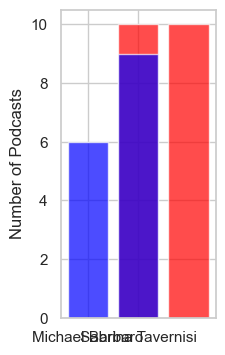

Text(0, 0.5, 'Number of Podcasts')

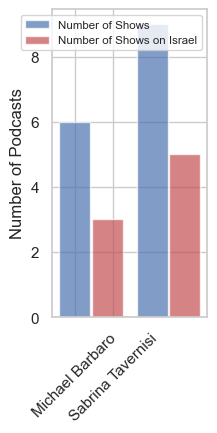

In [140]:
# make a grouped bar plot for the number of rows with 'Michael Barbaro' vs. 'Sabrina Tavern' with max_fuzzy > 0.9
# and the number of rows with the topic word with max_fuzzy > 0.9
# make a plot as to the number of rows with 'Michael Barbaro' vs. 'Sabrina Tavern' with max_fuzzy > 0.9
sns.set_theme(style="whitegrid")
plt.figure(figsize=(2, 4))
hosts = target_word_list[:2]
topic = target_word_list[2]
# for each host find the number of rows with max_fuzzy > 0.9 and plot
for h_idx, host in enumerate(hosts):
	spacing = 0
	if h_idx > 0:
		spacing = 1
	# find the number of rows with max_fuzzy > 0.9 for the host
	host_df = transcript_df[transcript_df[f'max_fuzzy_{host}'] > 0.85]
	# find the number of rows with max_fuzzy > 0.9 for the topic
	topic_df = host_df[host_df[f'max_fuzzy_{topic}'] > 0.85]
	num_shows = host_df.shape[0]
	num_shows_topic = topic_df.shape[0]
	# plot as double bar graph with host and topic
	if h_idx == 0:
		plt.bar(h_idx+spacing, num_shows, color='b', alpha=0.7, label='Number of Shows')
		plt.bar(h_idx+spacing+0.85, num_shows_topic, color='r', alpha=0.7, label=f'Number of Shows on {topic}')
	else:
		plt.bar(h_idx+spacing, num_shows, color='b', alpha=0.7)
		plt.bar(h_idx+spacing+0.85, num_shows_topic, color='r', alpha=0.7)
plt.xticks([0, 1], hosts)
# rotate the x-axis labels
plt.xticks(rotation=45)
# smaller font size
plt.legend(loc='upper right', fontsize='x-small')
plt.ylabel('Number of Podcasts')